# Expression Cloning

In [2]:
import igl
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

In [3]:
def get_vertex_to_face_map(V, F):
    """
    For each vertex, returns a list of face indices it belongs to.

    Args:
        V (np.ndarray): Vertices array of shape (n, 3)
        F (np.ndarray): Faces array of shape (m, 3)

    Returns:
        vertex_face_map (list of lists): vertex_face_map[i] contains the list of face indices that vertex i belongs to
    """
    num_vertices = V.shape[0]
    vertex_face_map = [[] for _ in range(num_vertices)]

    for face_idx, face in enumerate(F):
        for vertex_idx in face:
            vertex_face_map[vertex_idx].append(face_idx)

    return vertex_face_map

def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one
    
    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/np.linalg.norm(Vt_nb, axis=1)[:,None]

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = Vt_nb - (_Vt * Vn)
    Vt = Vt/np.linalg.norm(Vt, axis=1, keepdims=True)
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/np.linalg.norm(Vb, axis=1, keepdims=True)
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_TriangleArea_foreach_vertex(V,F):
    """
    Returns (V,)
    """
    DArea = igl.doublearea(V, F) * 0.5
    print(DArea.shape)

    V2F = get_vertex_to_face_map(V,F)
    VArea = []
    for v2f in V2F:
        VArea.append(np.sum(DArea[v2f])/len(v2f))
    VArea = np.array(VArea)
    return VArea

def get_scale_foreach_vertex(V,F):
    """
    Returns (V, 3)
    """
    # Vxyz = []
    # for vf in V[F]: # F, 3, 3
    #     Vxyz.append(vf.max(0)-vf.min(0))
    # Vxyz = np.array(Vxyz)
    
    V2F = get_vertex_to_face_map(V,F)
    Vscale = []
    for v2f in V2F:
        Vscale.append(np.std(V[F[v2f]].reshape(-1,3), axis=0))
    Vscale = np.array(Vscale)
    return Vscale

def get_scale_foreach_triangle(Vsrc, Vdef, Fsrc):
    """
    get scale ratio of DeformedSourceModelLocalBoudingBox / SourceModelLocalBoudingBox
    Returns (V, 3, 3)
    """
    S_matrices = np.zeros((Vsrc.shape[0], 3))

    all_nbh = igl.adjacency_list(Fsrc) # all neighbors for each vertex    
    for v_idx, nbh in enumerate(all_nbh):

        # get positions in both source and deformed meshes
        local_src = Vsrc[nbh]
        local_def = Vdef[nbh]

        # bounding box: max - min
        bbox_src = np.max(local_src, axis=0) - np.min(local_src, axis=0)
        bbox_def = np.max(local_def, axis=0) - np.min(local_def, axis=0)

        # prevent divide by zero
        bbox_src[bbox_src == 0] = 1e-8

        scale = bbox_def / bbox_src  # (3,)
        S_matrices[v_idx] = scale

    return S_matrices

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L.T @ I_L
    
    vert = I_L @ vert
    return vert

def taubin_smooth(vert, lap, values, loop=2, m=0.01, l=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*l
    I_M = scipy.sparse.identity(lap.shape[0]) - _lap*m
    
    I_L = I_L @ I_M
    for i in range(loop-1):
        I_L = I_L @ I_L
    
    values = I_L @ values
    return values

def mesh_smooth(V, F, values, tau=0.001):

    # Mesh smoothing with libigl
    l = igl.cotmatrix(V, F)  # laplace-beltrami operator in libigl
    m = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_BARYCENTRIC) # mass matrix in libigl
    s = m - tau * l
    return spsolve(s, m @ values)

def random_rotation_matrix(randgen=None):
    """
    Borrowed from https://github.com/nmwsharp/diffusion-net/blob/master/src/diffusion_net/utils.py
    
    Creates a random rotation matrix.
    randgen: if given, a np.random.RandomState instance used for random numbers (for reproducibility)
    """
    # adapted from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randgen is None:
        randgen = np.random.RandomState()
        
    theta, phi, z = tuple(randgen.rand(3).tolist())
    
    theta = theta * 2.0*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0 # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M
    
def random_rotate_points(pts, randgen=None, return_rot=False):
    R = random_rotation_matrix(randgen) 
    if return_rot:
        return np.matmul(pts, R), R
    return np.matmul(pts, R)


## create mesh set

In [4]:
V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

newV, newF = igl.read_triangle_mesh("m02_deformed-0.2.obj")
## Note that both mesh has same mesh structure! -> F == newF
newV = rescale(newV ,V)
R = np.eye(3)
newV, R = random_rotate_points(newV, return_rot=True)

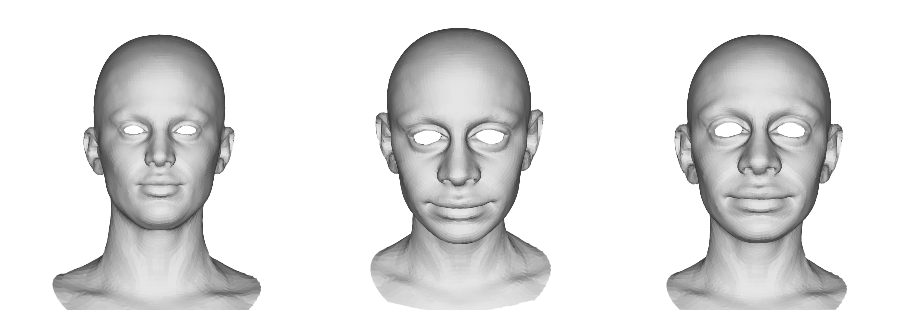

In [5]:
from matplotrender.src.matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, newV, np.matmul(newV,R.T) ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Animation for the source mesh

In [44]:
# motions = np.load(r'_tmp\040.npy')
# print(motions.shape)

from utils.ict_face_model import ICT_face_model
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 26
BS1 = 26
BS2=5

# motions = np.load(r'_tmp\040.npy')
# displacements = motions - V[None]

displacements = blendshapes[BS1]+blendshapes[BS2]
print(displacements.shape, displacements.max())

(11248, 3) 0.083766006


## Get local coordinate system via TBN matrix

In [384]:
V_TBN = get_TBN_foreach_vertex(V, F)
newV_TBN = get_TBN_foreach_vertex(newV, F)

## Scale using BB

In [ ]:
# Vs = get_scale_foreach_vertex(V, F)
# newVs = get_scale_foreach_vertex(newV, F)
# newS = newVs/Vs
newS = get_scale_foreach_triangle(V, np.matmul(newV, R.T), F)
# newS = abs(newS)

    
newS = gaussian_filter(newS, 5, mode='nearest')

# Lap = igl.cotmatrix(V, F)
# newS = smooth(newS, Lap, loop=2, t=0.03)

newS = mesh_smooth(V, F, newS, tau=0.1)
# newS[:,0] = gaussian_filter1d(newS[:,0], 3,mode='nearest')
# newS[:,1] = gaussian_filter1d(newS[:,1], 3,mode='nearest')
# newS[:,2] = gaussian_filter1d(newS[:,2], 3,mode='nearest')

# max_std = newS.std(0)*3
# for i in range(3):
#     tmp = newS[:, i]
#     tmp[tmp > max_std[i]] = max_std[i]
#     newS[:, i] = tmp

# newS = newS @ np.eye(3)
newS = np.eye(3)[None,:,:] * newS[:,:,None]
print(newS.shape)

(11248, 3, 3)


## Animation with Motion Vectors

In [427]:
# MAT = newS * np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newS, MAT)


new_displacements = np.einsum('bck, bk->bc', MAT, displacements)

## filtering...
new_displacements = mesh_smooth(V, F, new_displacements, tau=0.001)
# lap = igl.cotmatrix(V, F)
# new_displacements = smooth(displacements, lap, loop=3, t=0.01)
print(new_displacements.shape, new_displacements.min(), new_displacements.max())

(11248, 3) -0.4638299506065637 0.08092119922323907


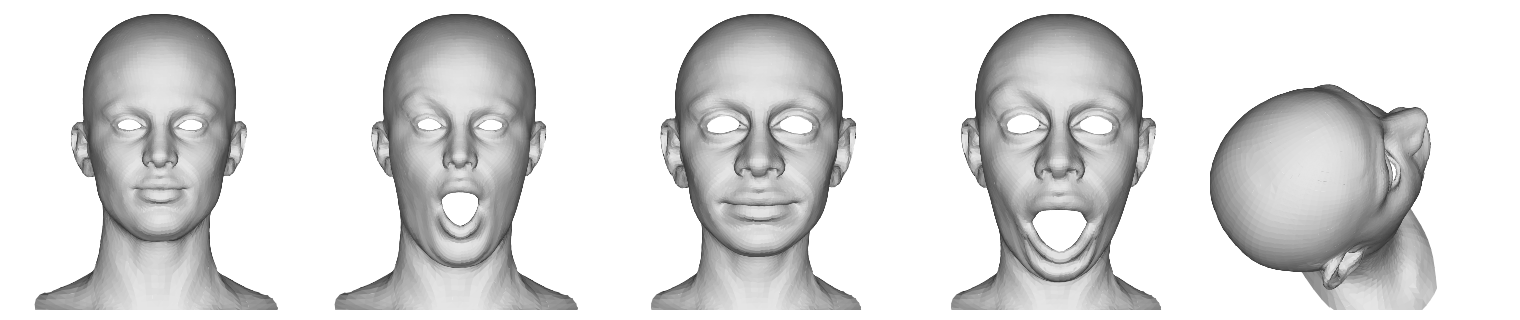

In [429]:
from matplotrender.src.matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7
mesh_trans = np.array([0,0,0])
# mesh that you wanna render

v_list=[ V, displacements+V, np.matmul(newV, R.T), np.matmul(new_displacements+newV, R.T), new_displacements+newV]
v_list=[ v*mesh_scale+mesh_trans for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

[000000] loss: 1.014e+00:   0%|          | 0/2000 [00:00<?, ?it/s]

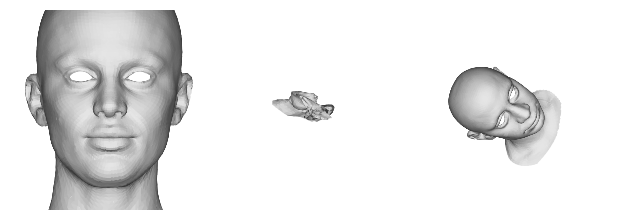

[000500] loss: 2.237e-04:  25%|██▍       | 499/2000 [00:21<01:05, 22.97it/s]

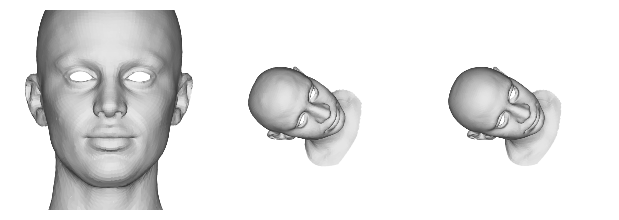

[001000] loss: 1.013e-04:  50%|█████     | 1000/2000 [00:43<00:41, 24.21it/s]

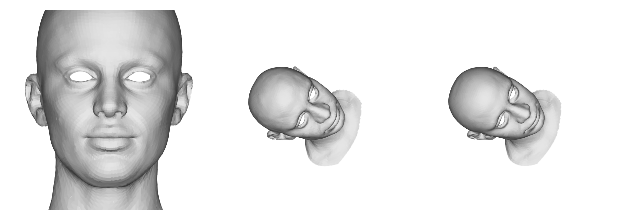

[001500] loss: 7.175e-05:  75%|███████▌  | 1500/2000 [01:05<00:22, 22.08it/s]

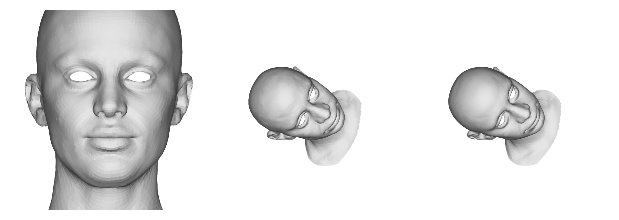

[001999] loss: 1.148e-04: 100%|██████████| 2000/2000 [01:27<00:00, 22.77it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim
from tqdm import tqdm

V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
## Note that both mesh has same mesh structure! -> F == newF
# newV = rescale(newV ,V)
newV = newV * 2
newV, R = random_rotate_points(newV,return_rot=True)


SIZE=2
lr = 2e-3

# w = torch.rand([V.shape[0],3,3]) * 1e-3
# w = w.requires_grad_(True)
# optimizer = torch.optim.Adam([w], lr=lr, betas=(0.9, 0.999))

model = nn.Sequential(
    nn.Linear(3, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(), nn.LayerNorm(64),
    nn.Linear(64, 64),  nn.ReLU(), nn.LayerNorm(64),
    nn.Linear(64, 128), nn.ReLU(), nn.LayerNorm(128),
    nn.Linear(128, 9),
)
optimizer = torch.optim.Adam([*model.parameters()], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 1

pbar = tqdm(range(2_000))
model.train()
for i in pbar:
    V_th = torch.tensor(V)[None].float()
    # v_trns = torch.bmm(torch.tensor(V)[:,None].float(), w)
    # v_trns = v_trns.squeeze(1)
    # loss = criterion(torch.tensor(newV).float(), v_trns)
    w = model(V_th).reshape(batch_size,-1,3,3)
    v_trns = torch.einsum('bnck,nk->bnc', w, torch.tensor(V).float())
    # orth_ = torch.einsum('bnck,bnki->bnci', w.transpose(-1, -2), w)

    # loss_orth = criterion(torch.eye(3)[None,None,None], orth_) * 0.1
    loss_v = criterion(torch.tensor(newV)[None].float(), v_trns)
    loss = loss_v#+loss_orth

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")

    if i % 500 == 0:
        v_list=[ V, v_trns[0].detach().numpy() *.2, newV*.2]
        v_list=[ v  for v in v_list ]
        f_list=[ F ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


In [104]:
from utils.ict_face_model import ICT_face_model
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 26
BS1 = 26
BS2=5

# motions = np.load(r'_tmp\040.npy')
# displacements = motions - V[None]

# displacements = blendshapes[BS1]+blendshapes[BS2]
displacements = ict.get_exp_disp(np.random.rand(1,53))[0]
print(displacements.shape, displacements.max())

(11248, 3) 0.2014994338774615


In [141]:

id_disp = ict.get_id_disp(np.random.rand(2,100))
id_disp.shape

(2, 11248, 3)

In [133]:
asd = torch.arange(5)+10
print(asd)
rp = torch.randperm(5)
print(rp)
rp_inv=torch.argsort(rp)

tensor([10, 11, 12, 13, 14])
tensor([0, 3, 1, 4, 2])


In [134]:

asdrp = asd[rp]
asdrp

tensor([10, 13, 11, 14, 12])

In [135]:
asdrp[rp_inv]

tensor([10, 11, 12, 13, 14])

tensor([2015, 7913, 8964,  ..., 2638, 6569, 8819])


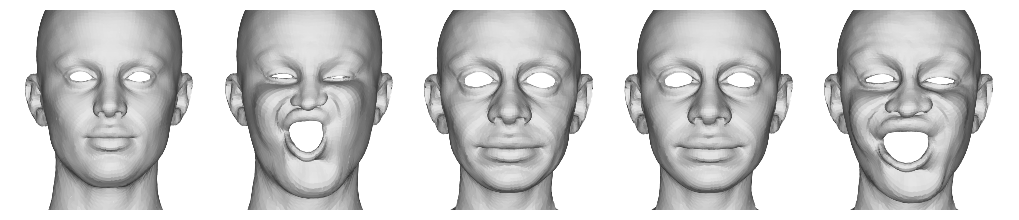

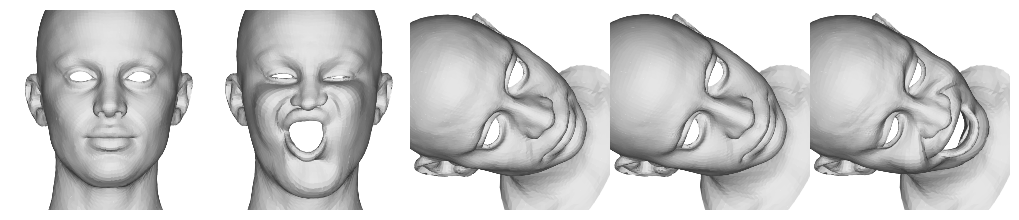

In [138]:
model.eval()

V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")
# V = V + np.array([0,0.2,0])


rp = torch.randperm(V.shape[0])
print(rp)
rp_inv=torch.argsort(rp)

V_th0 = torch.tensor(V)[rp][None].float()
# V = ict.neutral_verts
# V_th0 = torch.tensor(ict.neutral_verts)[None].float()
w0 = model(V_th0).reshape(batch_size,-1,3,3)
w0 = w0[:, rp_inv]
v_trns = torch.einsum('bnck,nk->bnc', w0, torch.tensor(V).float())




new_displacements = torch.einsum('bnck,nk->bnc', w0, torch.tensor(displacements).float())

## filtering...
# new_displacements = mesh_smooth(V, F, new_displacements, tau=0.001)


# v_list=[ V, v_trns[0].detach().numpy() *.2, (new_displacements+v_trns)[0].detach().numpy() *.2, newV*.2]
v_list=[ V, displacements+V, np.matmul(v_trns[0].detach().numpy(),R.T)*.45, np.matmul(newV,R.T)*.45, np.matmul((new_displacements+v_trns)[0].detach().numpy(),R.T)*.45]
v_list=[ v  for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

v_list=[ V, displacements+V, v_trns[0].detach().numpy() *.45, newV*.45, (new_displacements+v_trns)[0].detach().numpy() *.45]
v_list=[ v  for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [142]:
ict.neutral_verts.shape

(11248, 3)

In [147]:

base_coord = torch.tensor(ict.neutral_verts).float()
ID_code = np.random.rand(2,100)
id_disp = ict.get_id_disp(ID_code)
ID_code = torch.tensor(ID_code).float()
id_vert = torch.tensor(id_disp).float() + base_coord[None]
print(id_vert.shape)
print(base_coord.shape)


torch.Size([2, 11248, 3])
torch.Size([11248, 3])


In [ ]:
base_coord = torch.tensor(ict.neutral_verts)[None].float()
ID_code = np.random.rand(batch_size, 100)
id_disp = ict.get_id_disp(ID_code) * 2
ID_code = torch.tensor(ID_code).float()
id_vert = torch.tensor(id_disp).float() + base_coord

[000000] loss: 5.929e-01:   0%|          | 0/4000 [00:00<?, ?it/s]

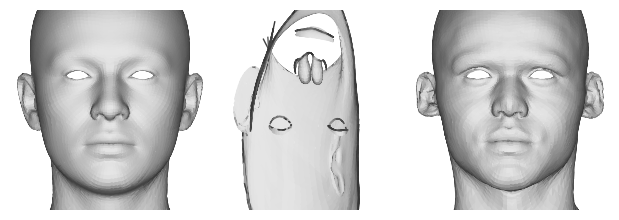

[000800] loss: 2.495e-04:  20%|█▉        | 795/4000 [00:13<00:53, 60.09it/s]

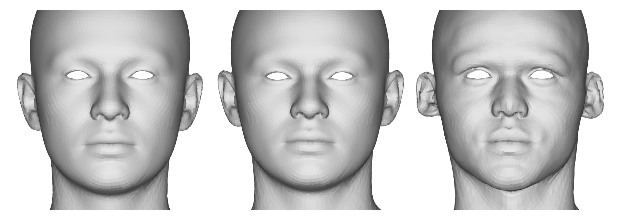

[001600] loss: 1.488e-04:  40%|████      | 1600/4000 [00:27<00:38, 61.88it/s]

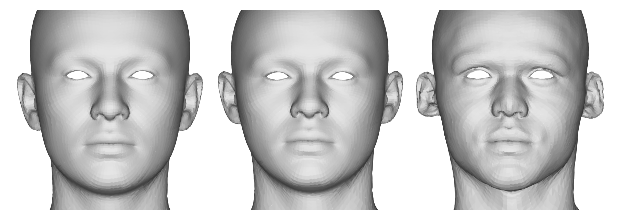

[002400] loss: 1.142e-04:  60%|██████    | 2400/4000 [00:40<00:25, 62.82it/s]

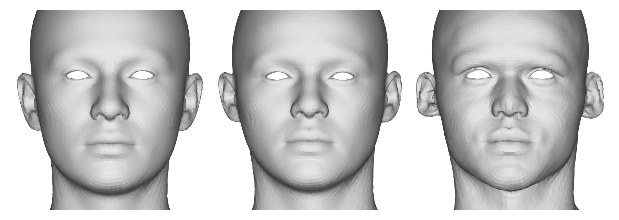

[003200] loss: 1.250e-04:  80%|███████▉  | 3197/4000 [00:53<00:12, 66.18it/s]

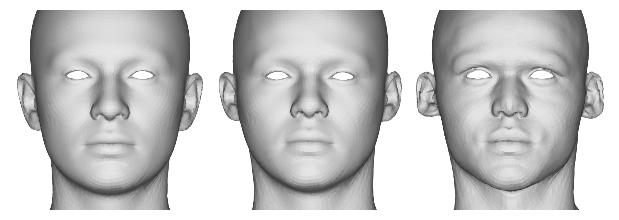

[003999] loss: 8.882e-05: 100%|██████████| 4000/4000 [01:06<00:00, 59.93it/s]


In [180]:
V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

SIZE=2
lr = 1e-3

model = nn.Sequential(
    nn.Linear(3+100, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(), nn.LayerNorm(64),
    nn.Linear(64, 64),  nn.ReLU(), nn.LayerNorm(64),
    nn.Linear(64, 128), nn.ReLU(), nn.LayerNorm(128),
    nn.Linear(128, 9),
)
optimizer = torch.optim.Adam([*model.parameters()], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 2


pbar = tqdm(range(4_000))
model.cuda()
model.train()
for i in pbar:
    
    N = base_coord.shape[1]

    V_th = base_coord.repeat(batch_size, 1, 1)
    
    V_th = torch.cat([V_th, ID_code[:,None].repeat(1, N, 1)], dim=-1).cuda()
    w = model(V_th).reshape(batch_size,N,3,3)

    v_trns = torch.einsum('bnck,bnk->bnc', w, base_coord.repeat(batch_size, 1, 1).cuda())

    loss = criterion(id_vert.cuda(), v_trns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")

    if i % 800 == 0:
        v_list=[ base_coord[0], v_trns[0].detach().cpu().numpy(), id_vert[0]]
        v_list=[ v  for v in v_list ]
        f_list=[ F ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


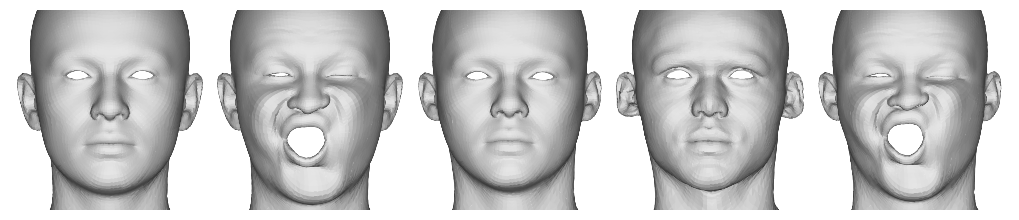

In [182]:
model.eval()

rp = torch.randperm(base_coord.shape[1])
rp_inv=torch.argsort(rp)

V_th1 = base_coord.repeat(batch_size, 1, 1)
V_th1 = V_th1[:, rp]
V_th1 = torch.cat([V_th1, ID_code[:, None].repeat(1, N, 1)], dim=-1)

w1 = model(V_th1.cuda()).reshape(batch_size,N,3,3)
w1 = w1[:, rp_inv]

v_trns1 = torch.einsum('bnck,bnk->bnc', w1, base_coord.repeat(batch_size, 1, 1).cuda()).cpu().detach()
new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().cuda() ).cpu().detach()

v_list=[ 
    base_coord[0].detach().numpy(),
    displacements+base_coord[0].detach().numpy(),
    v_trns1[0].detach().numpy(),
    id_vert[0],
    (new_disp1+v_trns1)[0]
]
v_list=[ v  for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


[000000] loss: 2.910e-01:   0%|          | 0/6000 [00:00<?, ?it/s]

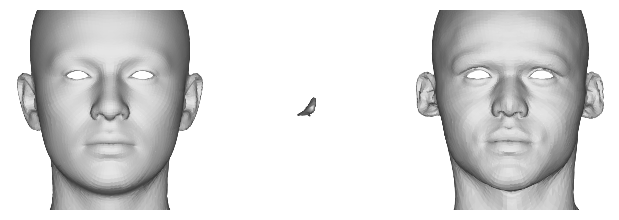

[001000] loss: 2.880e-05:  17%|█▋        | 996/6000 [00:16<01:15, 66.02it/s]

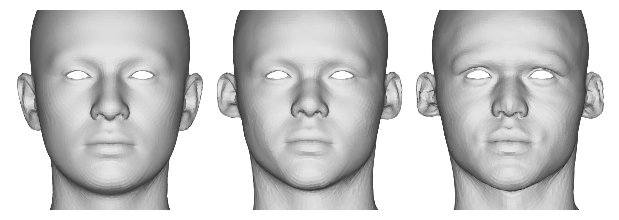

[002000] loss: 2.203e-05:  33%|███▎      | 1997/6000 [00:32<01:01, 64.75it/s]

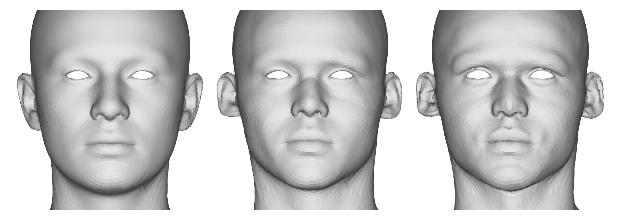

[003000] loss: 1.686e-05:  50%|████▉     | 2997/6000 [00:48<00:47, 62.64it/s]

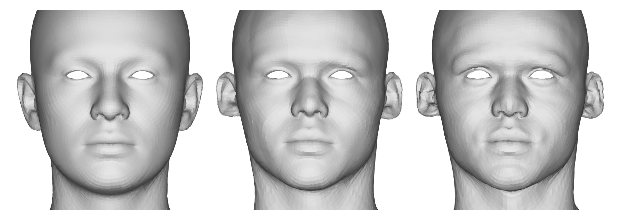

[004000] loss: 1.891e-05:  67%|██████▋   | 3999/6000 [01:04<00:31, 64.15it/s]

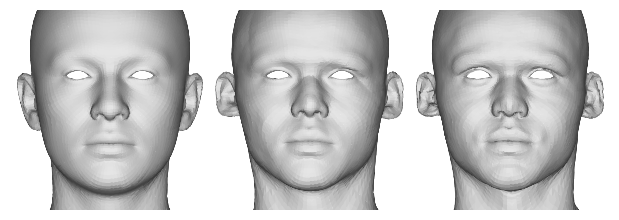

[005000] loss: 1.338e-05:  83%|████████▎ | 4996/6000 [01:20<00:15, 64.94it/s]

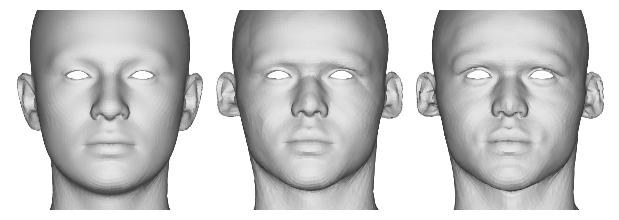

[005999] loss: 1.079e-05: 100%|██████████| 6000/6000 [01:36<00:00, 61.86it/s]


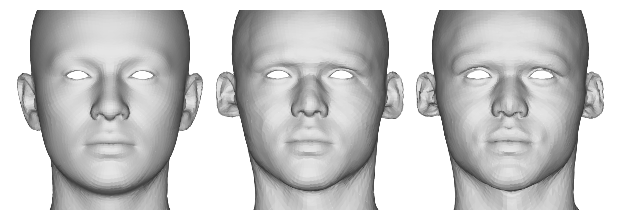

In [277]:
V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

SIZE=2
lr = 2e-3

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.ReLU()
        self.layer_in = nn.Linear(3, 64)
        self.layer_out = nn.Linear(64, 9)

        self.layers = nn.ModuleList([
            nn.Linear(64, 64),
            nn.Linear(64, 64), 
            nn.Linear(64, 64),
        ])
        self.norms = nn.ModuleList([
            nn.LayerNorm(64),
            nn.LayerNorm(64),
            nn.LayerNorm(64),
        ])

        self.adain_in = nn.Linear(100, 64)
        self.adains_m = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
        ])
        self.adains_s = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
        ])

    def forward(self, x_in, id_in):
        out = self.act(self.layer_in(x_in))
        id_in = self.act(self.adain_in(id_in))

        # for n, l, mu in zip(self.norms, self.layers, self.adains_m):
        #     out = n(self.act(l(out)))
        #     mu, sig = mu(id_in).chunk(2, dim=-1)
        #     out = out * sig + mu
        # out = self.layer_out(out)

        for n, l, mu, sigma in zip(self.norms, self.layers, self.adains_m, self.adains_s):
            out = n(self.act(l(out)))
            out = out * sigma(id_in) + mu(id_in)
        out = self.layer_out(out)

        # demodulate = True
        # for n, l, mu, sigma in zip(self.norms, self.layers, self.adains_m, self.adains_s):
        #     _s = sigma(id_in).squeeze()
        #     _m = mu(id_in)

        #     w = l.weight.unsqueeze(0)
        #     b = l.bias.unsqueeze(0)

        #     if demodulate:
        #         w = w * w.square().mean([1], keepdim=True).rsqrt()
        #         _s = _s * _s.square().mean().rsqrt()
        #         _m = _m * _m.square().mean().rsqrt()

        #     w = (w*_s.unsqueeze(1))
        #     b = (b*_m)

        #     if demodulate:
        #         dcoefs = (w.square().sum(dim=[2]) + 1e-8).rsqrt() # [NO]
        #         w = w * dcoefs.unsqueeze(1) # [NOIkk]

        #     out = torch.bmm(out, w.transpose(-1,-2)) + b

        #     out = n(self.act(out))
        # out = self.layer_out(out)
        return out
    
model = Model()
optimizer = torch.optim.Adam([*model.parameters()], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 2

pbar = tqdm(range(6_000))
model.cuda()
model.train()
for i in pbar:
    
    N = base_coord.shape[1]

    V_th = base_coord.repeat(batch_size, 1, 1)
    
    w = model(V_th.cuda(), ID_code[:,None].cuda()).reshape(batch_size,N,3,3)
    v_trns = torch.einsum('bnck,bnk->bnc', w, V_th.cuda())

    loss = criterion(id_vert.cuda(), v_trns)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")

    if i % 1000 == 0:
        v_list=[ base_coord[0], v_trns[0].detach().cpu().numpy(), id_vert[0]]
        v_list=[ v  for v in v_list ]
        f_list=[ F ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

v_list=[ base_coord[0], v_trns[0].detach().cpu().numpy(), id_vert[0]]
v_list=[ v  for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


In [270]:
# model.layers[0].bias.shape
_s = model.adains_s[0](model.adain_in(ID_code[:, None].cuda())).squeeze()
_m = model.adains_m[0](model.adain_in(ID_code[:, None].cuda())).squeeze()
w = model.layers[0].weight
b = model.layers[0].bias

w = (w.unsqueeze(0)*_s.unsqueeze(1))
# (b.unsqueeze(0)*_m.unsqueeze(1)).shape
# w.t() @ _s

In [ ]:
dcoefs = (w.square().sum(dim=[2]) + 1e-8).rsqrt() # [NO]
dcoefs.shape

torch.Size([2, 64])

In [238]:
model.eval()

rp = torch.randperm(base_coord.shape[1])
rp_inv=torch.argsort(rp)


V_th1 = base_coord.repeat(batch_size, 1, 1)
V_th1 = V_th1[:, rp]
# V_th1 = torch.cat([V_th1, ID_code[:, None].repeat(1, N, 1)], dim=-1)

w1 = model(V_th1.cuda(), ID_code[:, None].cuda()).reshape(batch_size,N,3,3)
w1 = w1[:, rp_inv]
v_trns1 = torch.einsum('bnck,bnk->bnc', w1, base_coord.repeat(batch_size, 1, 1).cuda()).cpu().detach()

new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().cuda() ).cpu().detach()


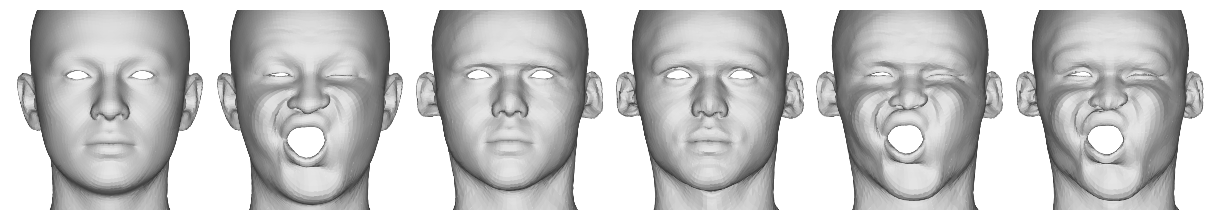

In [278]:

v_list=[ 
    base_coord[0].detach().numpy(),
    # id_disp[0]+base_coord[0].detach().numpy(),
    displacements+base_coord[0].detach().numpy(),
    v_trns1[0].detach().numpy(),
    id_vert[0],
    (new_disp1+v_trns1)[0],
    (new_disp1+id_vert)[0],
]
# v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
v_list=[ v for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

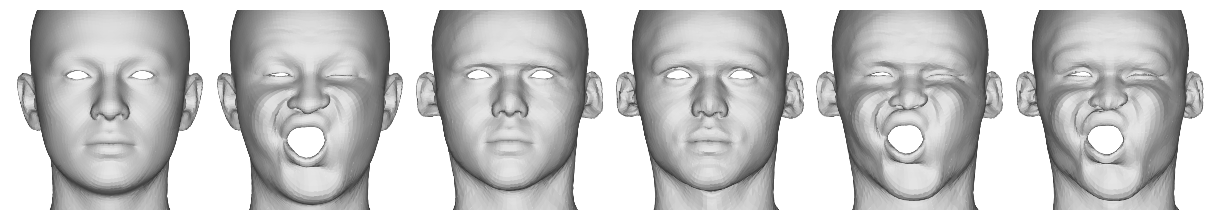

In [243]:
model.eval()

rp = torch.randperm(base_coord.shape[1])
rp_inv=torch.argsort(rp)


V_th1 = base_coord.repeat(batch_size, 1, 1)
V_th1 = V_th1[:, rp]
# V_th1 = torch.cat([V_th1, ID_code[:, None].repeat(1, N, 1)], dim=-1)

w1 = model(V_th1.cuda(), ID_code[:, None].cuda()).reshape(batch_size,N,3,3)
w1 = w1[:, rp_inv]
v_trns1 = torch.einsum('bnck,bnk->bnc', w1, base_coord.repeat(batch_size, 1, 1).cuda()).cpu().detach()

new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().cuda() ).cpu().detach()

v_list=[ 
    base_coord[0].detach().numpy(),
    # id_disp[0]+base_coord[0].detach().numpy(),
    displacements+base_coord[0].detach().numpy(),
    v_trns1[0].detach().numpy(),
    id_vert[0],
    (new_disp1+v_trns1)[0],
    (new_disp1+id_vert)[0],
]
# v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
v_list=[ v for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

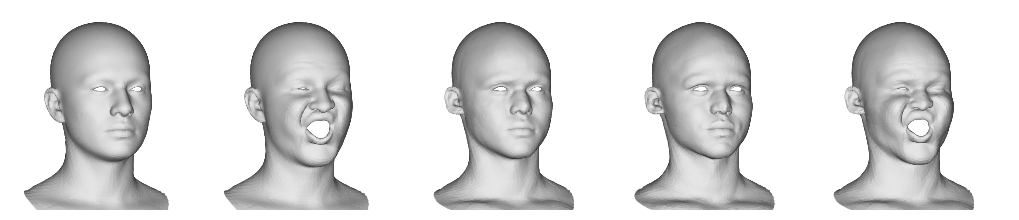

In [ ]:

v_list=[ 
    base_coord[0].detach().numpy(),
    # id_disp[0]+base_coord[0].detach().numpy(),
    displacements+base_coord[0].detach().numpy(),
    v_trns1[0].detach().numpy(),
    id_vert[0],
    (new_disp1+v_trns1)[0]
]
# v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
v_list=[ v*.6 for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,20,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

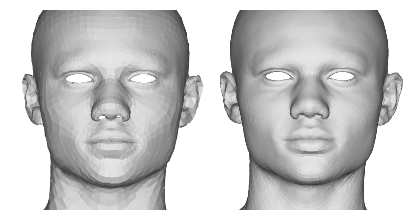

In [291]:
tmp_trimesh = trimesh.load(r'data\ict_live_100_000.obj')
id_keys=np.load(r'data\random_identity_vecs.npy')
id_tmp = ict.apply_coeffs(id_coeff=id_keys[0][None])[0]

v_list=[ tmp_trimesh.vertices, id_tmp]
f_list=[ tmp_trimesh.faces, F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


[000000] loss: 2.643e-01:   0%|          | 0/6000 [00:00<?, ?it/s]

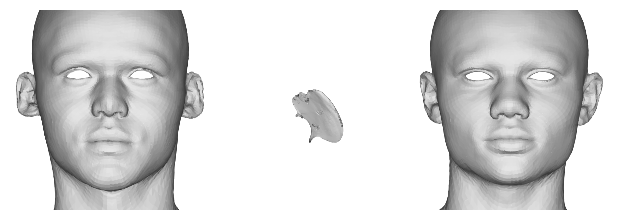

[001000] loss: 4.363e-05:  17%|█▋        | 994/6000 [00:17<01:25, 58.89it/s]

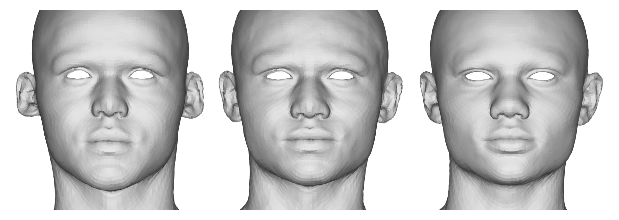

[002000] loss: 2.850e-05:  33%|███▎      | 1994/6000 [00:34<01:06, 60.29it/s]

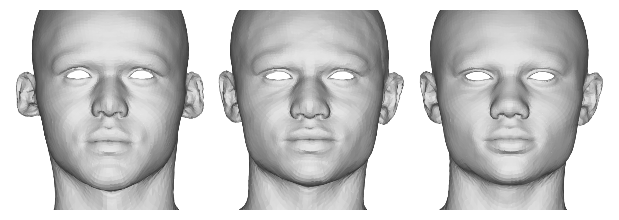

[003000] loss: 2.436e-05:  50%|█████     | 3000/6000 [00:51<00:46, 63.91it/s]

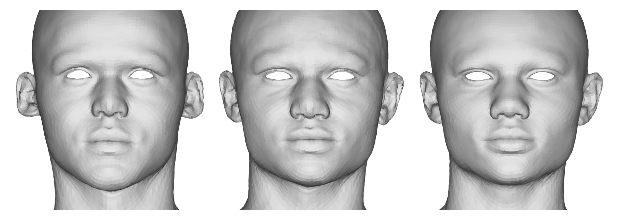

[004000] loss: 1.871e-05:  67%|██████▋   | 3996/6000 [01:07<00:32, 61.89it/s]

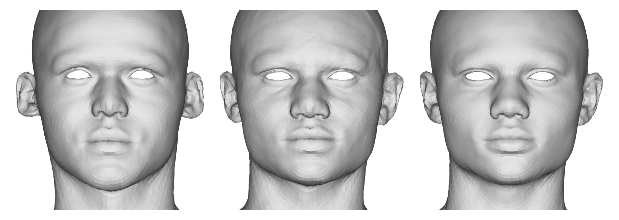

[005000] loss: 1.287e-05:  83%|████████▎ | 4999/6000 [01:24<00:15, 65.81it/s]

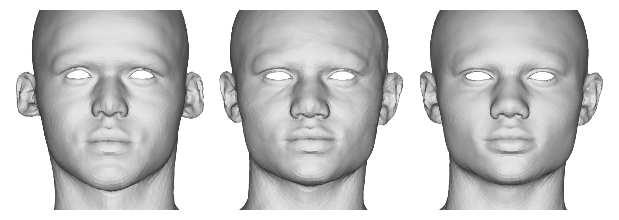

[005999] loss: 1.940e-05: 100%|██████████| 6000/6000 [01:41<00:00, 59.37it/s]


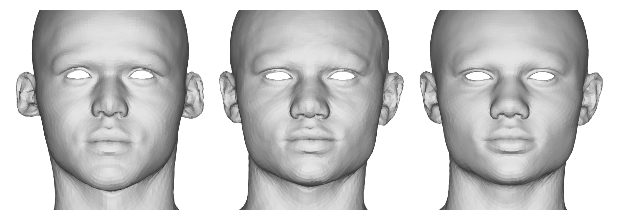

In [292]:
V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

SIZE=2
lr = 3e-3

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.ReLU()
        self.layer_in = nn.Linear(3, 64)
        self.layer_out = nn.Linear(64, 9)

        self.layers = nn.ModuleList([
            nn.Linear(64, 64),
            nn.Linear(64, 64), 
            nn.Linear(64, 64),
        ])
        self.norms = nn.ModuleList([
            nn.LayerNorm(64),
            nn.LayerNorm(64),
            nn.LayerNorm(64),
        ])

        self.adain_in = nn.Linear(100, 64)
        self.adains_m = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
        ])
        self.adains_s = nn.ModuleList([
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
            nn.Sequential(
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64), nn.ReLU(), #nn.LayerNorm(64), 
                nn.Linear(64, 64),
            ),
        ])

    def forward(self, x_in, id_in):
        out = self.act(self.layer_in(x_in))
        id_in = self.act(self.adain_in(id_in))

        for n, l, mu, sigma in zip(self.norms, self.layers, self.adains_m, self.adains_s):
            out = n(self.act(l(out)))
            out = out * sigma(id_in) + mu(id_in)
        out = self.layer_out(out)

        return out
    
model = Model()
optimizer = torch.optim.Adam([*model.parameters()], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 2

base_coord = torch.tensor(id_tmp)[None].float()

pbar = tqdm(range(6_000))
model.cuda()
model.train()
for i in pbar:
    
    N = base_coord.shape[1]

    V_th = base_coord.repeat(batch_size, 1, 1)
    
    # w = model(V_th.cuda(), ID_code[:,None].cuda()).reshape(batch_size,N,3,3)
    # v_trns = torch.einsum('bnck,bnk->bnc', w, V_th.cuda())
    w = model(id_vert.cuda(), ID_code[:,None].cuda()).reshape(batch_size,N,3,3)
    v_pred = torch.einsum('bnck,bnk->bnc', w, id_vert.cuda())

    loss = criterion(V_th.cuda(), v_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")

    if i % 1000 == 0:
        v_list=[ id_vert[0], v_pred[0].detach().cpu().numpy(), V_th[0]]
        v_list=[ v  for v in v_list ]
        f_list=[ F ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

v_list=[ id_vert[0], v_pred[0].detach().cpu().numpy(), V_th[0]]
v_list=[ v  for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


In [302]:
optim_coord.shape

torch.Size([1, 3694, 3])

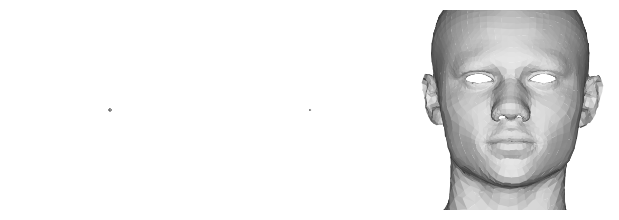

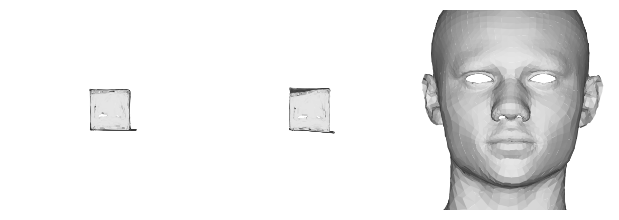

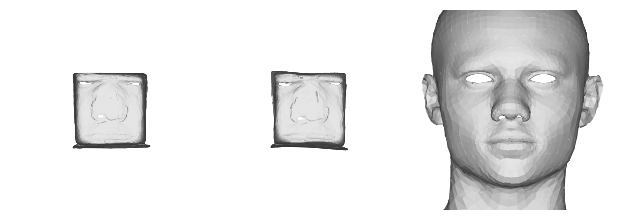

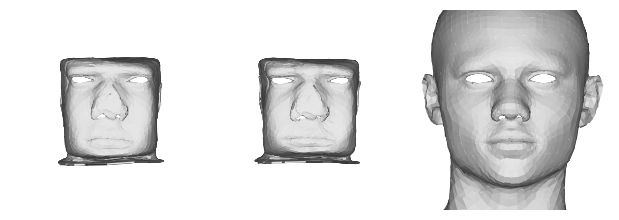

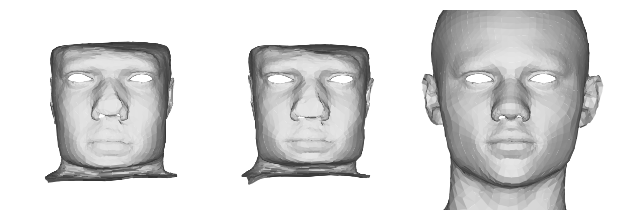

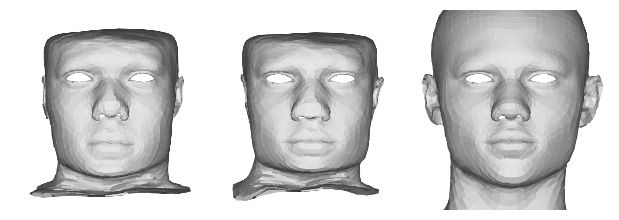

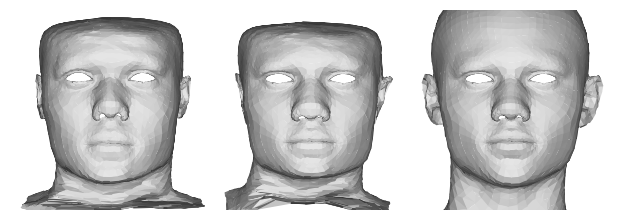

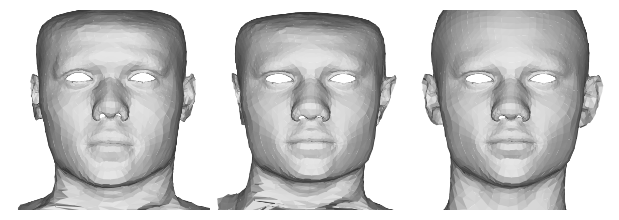

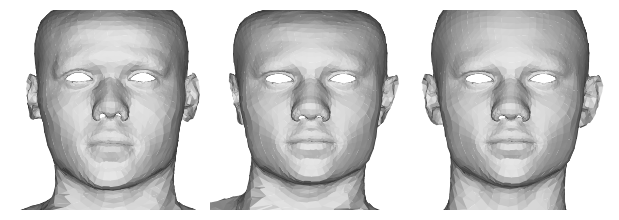

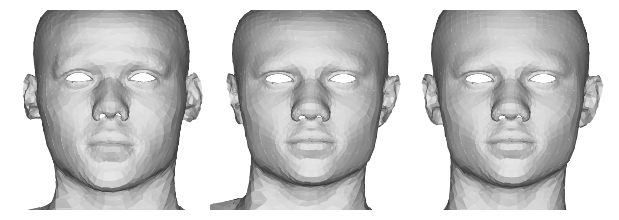

In [ ]:
model.eval()

# rp = torch.randperm(base_coord.shape[1])
# rp_inv=torch.argsort(rp)
NN = tmp_trimesh.vertices.shape[0]
gt_vert = torch.tensor(tmp_trimesh.vertices)[None].float()
optim_coord = torch.randn(gt_vert.shape).float() *1e-3
optim_coord = optim_coord.cuda().requires_grad_(True)

lr = 2e-3
optimizer = torch.optim.Adam([optim_coord], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 1

pbar = tqdm(range(1_000))
for i in pbar:

    w1 = model(optim_coord, ID_code[0][None,None].cuda()).reshape(batch_size,NN,3,3)
    pred_vert = torch.einsum('bnck,bnk->bnc', w1, optim_coord)

    loss = criterion(gt_vert.cuda(), pred_vert)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().cuda() ).cpu().detach()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")
    if i % 100==0:
        v_list=[ 
            optim_coord[0].detach().cpu().numpy(),
            pred_vert[0].detach().cpu().numpy(),
            tmp_trimesh.vertices,
        ]
        # v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
        # v_list=[ v for v in v_list ]
        f_list=[ tmp_trimesh.faces ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')